In [373]:
import torch
import random
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from scipy.stats import norm
from scipy.stats.distributions import chi2
from random import shuffle
from matplotlib.animation import FuncAnimation

## Creating Dataset

In [374]:
# Fix seeds
random.seed(15)
np.random.seed(15)
torch.manual_seed(15)


c1 = plt.get_cmap('coolwarm')(0.0)
c2 = plt.get_cmap('coolwarm')(1.0)

plt_cmap = sns.color_palette("coolwarm", as_cmap=True)

In [375]:
def make_dataset(mean, cov, v=None, separation=1, n=200):
    x1 = np.random.multivariate_normal(mean, cov, size=n)
    if v is None:
        v = np.random.randn(2,)
        v = separation * (v / np.linalg.norm(v)).reshape(1, -1)
    elif np.linalg.norm(v) != separation:
        v = separation * (v / np.linalg.norm(v)).reshape(1, -1)
    else:
        v = v.reshape(1, -1)
    x2 = x1 + v
    X = np.concatenate([x1, x2], axis=0)
    y = np.array([0] * len(x1) + [1] * len(x2))

    return X, y

In [376]:
n_dim = 2
n_classes = 2
n_datasets = 4
device = 'cpu'

In [377]:
mu = np.array([0, 0])
separation = 6
A = np.random.randn(2, 2)
cov = .1 * np.dot(A.T, A) + np.eye(2)
v = np.array([np.cos((np.pi / 180) * 45), np.sin((np.pi / 180) * 45)])
X, y = make_dataset(mu, cov, v=v, separation=separation, n=400)
Xt = torch.from_numpy(X).float()
Yt = torch.nn.functional.one_hot(torch.from_numpy(y).long(), num_classes=2).float()


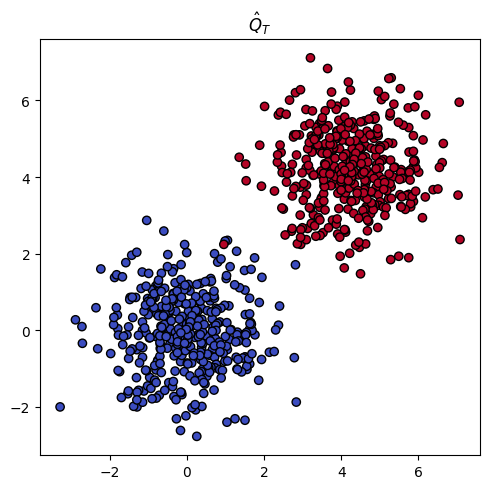

In [378]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

ax.scatter(x=Xt[:, 0], y=Xt[:, 1], c=y, cmap='coolwarm', edgecolor='k')
ax.set_title(r"$\hat{Q}_{T}$")
plt.tight_layout()

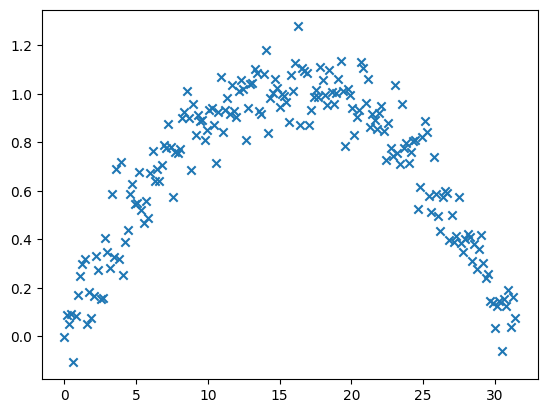

In [379]:
abs = np.linspace(0, 10*np.pi, 200)
np.random.seed(None)
def arc(x):
    return np.sin(x/10) + np.random.normal(0.05, 0.1, 200)

X_arc = np.concatenate((abs.reshape((200, 1)), arc(abs).reshape((200, 1))), axis=1)

fig, ax = plt.subplots(1, 1)
ax.scatter(X_arc[:, 0], X_arc[:, 1], marker = 'x')

## Python implementation of 'ONLINE LEARNING OF GAUSSIAN MIXTURE MODELS: A TWO-LEVEL APPROACH' by Arnaud Declercq, Justus H. Piater

Global Variables

In [380]:
N = len(X)
n_features = 2
precise_fidelity_threshold = 0.8
uncertain_fidelity_threshold = np.exp(N*np.log(precise_fidelity_threshold)/(chi2.ppf(0.05, N-1)))
point_covariance_matrix = np.eye(2)

Utility functions

In [381]:
def initialize_ecdf(x1, x2):
    new_gaussian1 = (x1, point_covariance_matrix, 1)
    new_gaussian2 = (x2, point_covariance_matrix, 1)
    precise_GMM = [new_gaussian1, new_gaussian2]
    uncertain_GMM = [new_gaussian1, new_gaussian2]
    ecdf = ([], [], [])

    for dim in range(len(x1)):
        intervals = ecdf[0]
        intervals.append(np.linspace(np.min((x1[dim], x2[dim])), np.max((x1[dim], x2[dim])), 10))
        populations = ecdf[1]
        populations.append([1, 0, 0, 0, 0, 0, 0, 0, 0, 1])

        ecdf = (intervals, populations, [])

    

    return precise_GMM, uncertain_GMM, ecdf


def ecdf_update(x, ecdf):
    '''
    Update the empirical cumulative distribution function

    params:
      x: new point
      ecdf: empirical cumulative distribution function
    
    return:
      ecdf: (intervals, population, values)
    '''

    intervals = ecdf[0]
    populations = ecdf[1]
    values = []
    for dim in range(len(intervals)):
        n_dim = len(intervals[dim])
        i = 0
        while i < n_dim and x[dim] > intervals[dim][i]:
            i += 1
        if i == 0:
            intervals[dim] = np.linspace(x[dim], intervals[dim][-1], 10)
            populations[dim][0] += 1
        elif i == n_dim:
            intervals[dim] = np.linspace(intervals[dim][0], x[dim], 10)
            populations[dim][-1] += 1
        else:
          populations[dim][i-1] += 1

        Q = np.sum(populations[dim])
        values_added = []
        for i in range(len(intervals[dim])):
            values_added.append(np.sum(populations[dim][:i])/Q)
        values.append(values_added)

    return intervals, populations, values


def ecdf_evaluate(x, ecdf):
    '''
    Evaluate the empirical cumulative distribution function at x

    params:
      x: point
      ecdf: empirical cumulative distribution function
    
    return:
      result: ecdf evaluated at x
    '''

    result = np.zeros(x.shape[0])
    for dim in range(x.shape[0]):
        i = 0
        while i < len(ecdf[0][dim]) and x[dim] > ecdf[0][dim][i]:
            i += 1
        if i == 0:
            result[dim] = 0
        else:
            result[dim] = ecdf[2][dim][i-1]
    
    return result


def tcdf(GMM, x):
    '''
    Compute the value of the theoretical cumulative distribution function of GMM at x
    '''
    result = np.zeros(n_features)
    for dim in range(n_features):
        mass_total = 0
        for i in range(len(GMM)):
            mass_total += GMM[i][2]
            result[dim] +=  GMM[i][2] * norm(GMM[i][0][dim], GMM[i][1][dim, dim]).cdf(x[dim])
        result[dim] /= mass_total

    return result

    

def fidelity(ecdf, GMM, T_D=0.5):
    '''
    Compute the fidelity of the Gaussian model

    params:
      ecdf: empirical cumulative distribution function
      rcdf: theoretical cumulative distribution function
      T_D: allowed deviation parameter

    return: 
      fidelity
    '''

    differences = np.zeros((len(ecdf[0][0]), n_features))
    
    for i in range(len(ecdf[0][0])):
        point = np.zeros(n_features)
        ecdf_values = np.zeros(n_features)
        for dim in range(n_features):
            point[dim] = ecdf[0][dim][i]
            ecdf_values[dim] = ecdf[2][dim][i]
        differences[i, :] = np.abs(ecdf_values - tcdf(GMM, point))
    
    distance = np.zeros(n_features)
    for dim in range(n_features):
      for i in range((len(ecdf[0][0]))):
          distance[dim] += differences[i, dim] * (ecdf[0][dim][1] - ecdf[0][dim][0])
    distance =  np.sum(distance) / len(ecdf[0][0])
    fidelity = np.exp(-distance**2/T_D**2)

    return fidelity


def nearest_neighbor(x, L):
    '''
    params:
      x: point of which we search the nearest neighbor
      L: list of points among which we search the nearest neighbor

    return:
      near_point_index: the nearest neighbor index
    '''
    dists= [np.linalg.norm((x - L[i])) for i in range(len(L))]
    near_point_index = np.argmin(dists)

    return near_point_index


def get_nearest_precise_GMM(candidate_index, uncertain_GMM, precise_GMM):
    '''
    params:
      candidate_index: index of the candidate in uncertain_GMM
      uncertain_GMM: uncertain GMM list
      precise_GMM: precise GMM list
    
    return:
      nearest_precise_GMM: indexes of precise GMMs that have the candidate as their nearest neighbor in uncertain_GMM
    '''
    nearest_precise_GMM_indexes = []
    for i in range(len(precise_GMM)):
        near_neighbor_index = nearest_neighbor(precise_GMM[i][0], [uncertain_GMM[j][0] for j in range(len(uncertain_GMM))])
        if near_neighbor_index == candidate_index:
            nearest_precise_GMM_indexes.append(i)
    
    return nearest_precise_GMM_indexes
        

Process functions

In [382]:
def precise_GMM_reduction(GMM, ecdf, threshold):
    simplified = False
    while not simplified:
        if len(GMM) > 1:
            nearest_neighbor_index = nearest_neighbor(GMM[-1][0], [GMM[j][0] for j in range(len(GMM)-1)])
            candidate = GMM[nearest_neighbor_index]

            new_mass = GMM[-1][2] + candidate[2]
            new_mean = 1/new_mass * (GMM[-1][2] * GMM[-1][0] 
                                    + candidate[2] * candidate[0])
            new_cov = GMM[-1][2]/new_mass * (GMM[-1][1] + np.dot((GMM[-1][0] - new_mean).T, (GMM[-1][0] - new_mean))) \
            + candidate[2]/new_mass * (candidate[1] + np.dot((candidate[0] - new_mean).T, (candidate[0] - new_mean)))

            mixed_gaussian = (new_mean, new_cov, new_mass)
            mixed_GMM = GMM.copy()
            del mixed_GMM[-1]
            del mixed_GMM[nearest_neighbor_index]
            mixed_GMM.append(mixed_gaussian)
            
            fidel = fidelity(ecdf, mixed_GMM)
            print(fidel)
            if fidel > threshold:
                GMM = mixed_GMM
            else:
                simplified = True
        else:
            simplified = True
    return GMM


def uncertain_GMM_reduction(GMM, ecdf, threshold):
    simplified = False
    while not simplified:
        if len(GMM) > 1:
            nearest_neighbor_index = nearest_neighbor(GMM[-1][0], [GMM[j][0] for j in range(len(GMM)-1)])
            candidate = GMM[nearest_neighbor_index]

            new_mass = GMM[-1][2] + candidate[2]
            new_mean = 1/new_mass * (GMM[-1][2] * GMM[-1][0] 
                                    + candidate[2] * candidate[0])
            new_cov = GMM[-1][2]/new_mass * (GMM[-1][1] + np.dot((GMM[-1][0] - new_mean).T, (GMM[-1][0] - new_mean))) \
            + candidate[2]/new_mass * (candidate[1] + np.dot((candidate[0] - new_mean).T, (candidate[0] - new_mean)))

            mixed_gaussian = (new_mean, new_cov, new_mass)
            mixed_GMM = GMM.copy()
            del mixed_GMM[-1]
            del mixed_GMM[nearest_neighbor_index]
            mixed_GMM.append(mixed_gaussian)

            fidel = fidelity(ecdf, mixed_GMM)

            if fidel > threshold:
                GMM = mixed_GMM

            else:
                GMM = uncertain_GMM_reduction(GMM[:-1], ecdf, threshold) + [GMM[-1]]
                simplified = True
        else:
            simplified = True
    return GMM


def uncertain_GMM_process(uncertain_GMM, precise_GMM, ecdf):
    if len(uncertain_GMM) > 1:
        candidate_index = nearest_neighbor(uncertain_GMM[-1][0], [uncertain_GMM[j][0] for j in range(len(uncertain_GMM)-1)])
        candidate = uncertain_GMM[candidate_index] 

        new_mass = uncertain_GMM[-1][2] + candidate[2]
        new_mean = 1/new_mass * (uncertain_GMM[-1][2] * uncertain_GMM[-1][0] 
                                + candidate[2] * candidate[0])
        new_cov = uncertain_GMM[-1][2]/new_mass * (uncertain_GMM[-1][1] + np.dot((uncertain_GMM[-1][0] - new_mean).T, (uncertain_GMM[-1][0] - new_mean))) 
        + candidate[2]/new_mass * (candidate[1] + np.dot((candidate[0] - new_mean).T, (candidate[0] - new_mean)))
        
        mixed_gaussian = (new_mean, new_cov, new_mass)

        mixed_uncertain_GMM = uncertain_GMM.copy()
        del mixed_uncertain_GMM[-1]
        del mixed_uncertain_GMM[candidate_index]
        mixed_uncertain_GMM.append(mixed_gaussian)
        
        fidel = fidelity(ecdf, mixed_uncertain_GMM)
        
        if fidel > uncertain_fidelity_threshold:
            uncertain_GMM = mixed_uncertain_GMM
        else:
            precise_GMM_indexes = get_nearest_precise_GMM(candidate_index, uncertain_GMM, precise_GMM)
            new_precise_GMM = [precise_GMM[i] for i in precise_GMM_indexes] + [uncertain_GMM[-1]]

            new_uncertain_GMM = uncertain_GMM_reduction([precise_GMM[i] for i in precise_GMM_indexes] 
                                                        + [uncertain_GMM[-1]], ecdf, uncertain_fidelity_threshold)
            del uncertain_GMM[candidate_index]
            del uncertain_GMM[-1]
            uncertain_GMM.extend(new_uncertain_GMM)

            new_precise_GMM = precise_GMM_reduction(new_precise_GMM, ecdf, precise_fidelity_threshold)
            precise_GMM_indexes.sort(reverse=True)
            for i in precise_GMM_indexes:
                del precise_GMM[i]
            precise_GMM.extend(new_precise_GMM)

    return uncertain_GMM, precise_GMM

In [383]:
def online_precise_GMM(X):
    gauss_history = []
    n = X.shape[0]
    #stock the different gaussians with format: (mean, covariance, mass)
    precise_GMM, _, ecdf = initialize_ecdf(X[0], X[1])
    gauss_history.append([precise_GMM[i][0] for i in range(len(precise_GMM))])


    for i in range(2, n):
        print(i)
        ecdf = ecdf_update(X[i], ecdf)
        new_gaussian = (X[i], point_covariance_matrix, 1)
        precise_GMM.append(new_gaussian)
        precise_GMM = precise_GMM_reduction(precise_GMM, ecdf, precise_fidelity_threshold)
        gauss_history.append([precise_GMM[i][0] for i in range(len(precise_GMM))])
    
    return precise_GMM, ecdf, gauss_history

In [384]:
def online_GMM(X):
    n = X.shape[0]
    #stock the different gaussians with format: (mean, covariance, mass)
    precise_GMM, uncertain_GMM, ecdf = initialize_ecdf(X[0], X[1])


    for i in range(2, n):
        print(i)
        ecdf = ecdf_update(X[i], ecdf)
        new_gaussian = (X[i], point_covariance_matrix, 1)
        uncertain_GMM.append(new_gaussian)
        uncertain_GMM, precise_GMM = uncertain_GMM_process(uncertain_GMM, precise_GMM, ecdf)
    
    return uncertain_GMM, precise_GMM

In [385]:
X = np.random.permutation(X_arc)
xmin, ymin = np.min(X, axis=0)[0], np.min(X, axis=0)[1]
xmax, ymax = np.max(X, axis=0)[0], np.max(X, axis=0)[1]

result = online_precise_GMM(X)

2
0.22063757566808131
3
0.5795890528578549
4
0.5095377379322047
5
0.6408148341176305
6
0.48376144467087623
7
0.5201812471463965
8
0.5783380199287699
9
0.4077027070680521
10
0.4844852161989843
11
0.4706303572625258
12
0.5249058777941049
13
0.5769982817384307
14
0.6578799368913298
15
0.6789430116705834
16
0.69383230112782
17
0.7089726275621504
18
0.7290136863296441
19
0.7483371670724057
20
0.7627410699827495
21
0.7788587808079126
22
0.7935797397883487
23
0.8087815389320195
0.8113009475030554
0.816121360282594
0.8124768949986387
0.809705501383476
0.821384426004572
0.8274317918208103
0.8199027050724762
0.776771298519815
24
0.8214107256350388
0.7748050190362117
25
0.8284516284352494
0.8272289120838282
0.8231933156599206
0.8189951432272752
0.8008579542863808
0.7855894328039595
26
0.8139494195074086
0.7867942160837378
27
0.8303706643295553
0.815447215090981
0.802989252163934
0.8062960030287898
0.8260155406399803
0.25753105535270016
28
0.811357920033902
0.7676353796447827
29
0.825196818981104


In [386]:
def plot_GMM(GMM, fig, ax):
    # Define the mean and covariance matrix
    for i in range(len(GMM)):
        mean = GMM[i][0]  # Mean of the distribution
        cov_matrix = GMM[i][1]  # Covariance matrix

        # Calculate the eigenvalues and eigenvectors of the covariance matrix
        eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

        # Get the major and minor axes lengths from the eigenvalues
        major_axis_length = 2.0 * np.sqrt(5.991 * eigenvalues[0])  # 95% confidence interval
        minor_axis_length = 2.0 * np.sqrt(5.991 * eigenvalues[1])  # 95% confidence interval

        # Calculate the angle of rotation from the eigenvectors
        angle = np.degrees(np.arctan2(eigenvectors[1, 0], eigenvectors[0, 0]))

        # Create an Ellipse object representing the covariance ellipse
        ellipse = patches.Ellipse(xy=mean, width=2 * np.sqrt(5.991 * eigenvalues[0]), height=2 * np.sqrt(5.991 * eigenvalues[1]),
                           angle=angle, fill=False, color='b', linestyle='dashed')

        # Add the ellipse to the plot
        ax.add_patch(ellipse)

        # Set the aspect ratio of the plot to 'equal' to ensure the ellipse is not distorted
        ax.set_aspect('equal', adjustable='box')

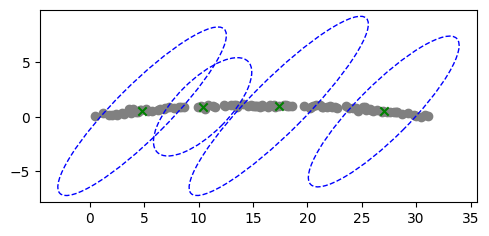

In [387]:
means = [result[0][i][0] for i in range(len(result[0]))]
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

ax.scatter(x=X[::2, 0], y=X[::2, 1], color='grey')
ax.scatter(x=[means[i][0] for i in range(len(means))], y=[means[i][1] for i in range(len(means))], marker = 'x', color='g', zorder=1)
plot_GMM(result[0], fig, ax)
plt.tight_layout()

In [388]:
frames = [(np.array(result[2][i]), X[i+1]) for i in range(len(result[2]))]

In [389]:
xmin, ymin = np.min(X, axis=0)[0], np.min(X, axis=0)[1]
xmax, ymax = np.max(X, axis=0)[0], np.max(X, axis=0)[1]

MovieWriter imagemagick unavailable; using Pillow instead.


C:\Users\SL276123\AppData\Local\Temp\ipykernel_18228\2077303857.py:13: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


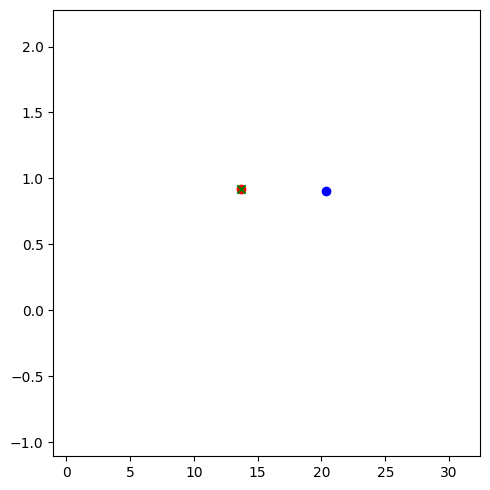

In [390]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

def update(frame):
    # clear the axis each frame
    ax.clear()
    
    # replot things
    ax.scatter(frame[0][:-1, 0], frame[0][:-1, 1], color='blue')
    ax.scatter(frame[0][-1, 0], frame[0][-1, 1], color='red')
    ax.scatter(frame[1][0], frame[1][1], color='green', marker='x')
    ax.set_xlim([xmin - 1, xmax + 1])
    ax.set_ylim([ymin - 1, ymax + 1])
    plt.tight_layout()

anim = FuncAnimation(fig, update, frames=frames, interval=10000)

anim.save('./animation.gif', writer='imagemagick', fps=10)